# Harris Corner Detector

The goal of this section is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sgl

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Harris Response Calculation

In [2]:
import math
def computeR(image,sigma,kappa = 0.04):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # Sobel Kernel
    Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    # Derivatives
    Ix = sgl.convolve2d(image,Gx,mode='same')
    Iy = sgl.convolve2d(image,Gy,mode='same')
    # Products
    Ix2 = Ix*Ix
    Iy2 = Iy*Iy
    Ixy = Ix*Iy

    # Convolutions
    convIx2 = sgl.convolve2d(Ix2,gaussianKernel(sigma),mode='same')
    convIy2 = sgl.convolve2d(Iy2,gaussianKernel(sigma),mode='same')
    convIxy = sgl.convolve2d(Ixy,gaussianKernel(sigma),mode='same')

    corners = np.zeros(image.shape)
    det = (convIx2 * convIy2) - convIxy**2
    trace = convIx2 + convIy2
    r = det - kappa*trace
    corners = r;
    
    max = 0
    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            if max < corners[i][j]:
                max = corners[i][j]
    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            corners[i][j] = corners[i][j]*255.0/max

    return corners

Experimenting the fuction on image ```img/house2.png```.

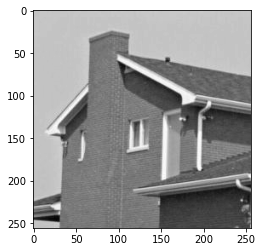

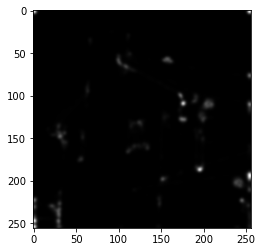

In [3]:
img = np.array(Image.open('img/house2.png'))
corners = computeR(img,2.2,0.04)
plt.gray()
plt.imshow(img)
plt.show()
plt.imshow(corners)
plt.show()

In harris response, we are using first derivatives in both directions. As we know before, homogeneous areas have slow variations and edges have quick variations in one direction. But corners have quick variations in both directions. So let say that L1 and L2 our eigen values. if L1 and L2 are both small, it means that we are examining some homogeneous area. If L1 > L2 or L2 > L1, then we are examining some edge area. If both L1 and L2 are high values and approximately equals to each other, then we are examining a corner. In harris response, we are calculating determinant and trace of the R matrix. Determinant = L1 * L2 and trace of the matrix = L1+L2. As we know from the basic math, if two values are close to each other they will give biggest value as possible if we multiply them and also give the smallest value if we add them. So in harris response we multiply these two values and subtract their sum from the multiplication. if they are close to each other the result will be high otherwise the result will be small. so this is how harris response give high values for corners and slow values for edges and homogeneous areas.

## Harris Corner Detector
From the Harris response calculated at previous section, we will write all the functions needed for the Harris detector.

In [4]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    Rb = np.copy(R)
    height = Rb.shape[0]
    width = Rb.shape[1]
    
    #traverse each pixel in the image
    for i in np.arange(height):
        for j in np.arange(width):
            # threshold check
            if Rb[i][j] > thres:
                Rb[i][j] = 255
            else:
                Rb[i][j] = 0
                
    return Rb

Function `Rnms(R, Rbin)` performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$ and returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

In [5]:
def rnms(image_harris,image_harrisB):
    """ Array[n, m] -> Array[n, m] 
    """
    height = image_harris.shape[0]
    width = image_harris.shape[1]
    # create Rlocmax
    Rlocmax = np.zeros((height,width))
    # traverse each pixel in the image
    for i in np.arange(1,height-1):
        for j in np.arange(1,width-1):
            valid = True
            # threshold check
            if image_harrisB[i][j] == 255:
                # traverse neighbors
                for x in np.arange(i-1,i+2):
                    for y in np.arange(j-1,j+2):
                        # check if any of the neighbors has bigger value
                        if image_harris[i][j] < image_harris[x][y]:
                            valid = False;
            else:
                continue # failed at threshold skip this iteration
            
            # threshold okey, valid is true if it has biggest value in neighborhood
            if valid == True:
                Rlocmax[i][j] = 255
            else:
                Rlocmax[i][j] = 0
                
    return Rlocmax

Finally, the function ``cornerDetector(image, scale, kappa, thresh)``.

In [6]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image,sigma,kappa)
    Rb = thresholdR(R,thres)
    result = rnms(R,Rb)
    return result

A function for better display the detected corners with red points.

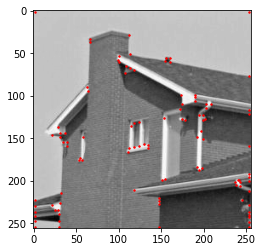

In [7]:
def display(img,sigma,kappa,thres,markersize):
    corners = cornerDetector(img,sigma,kappa,thres)
    nonzeroPoints = np.nonzero(corners)
    plt.scatter(nonzeroPoints[1],nonzeroPoints[0],markersize,c='#ff0000')
    plt.imshow(img)
    plt.show()
    
img = np.array(Image.open('img/house2.png'))
display(img,1,0.04,5,2)

## Properties of Harris Corner Detector

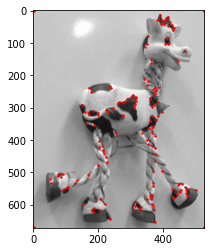

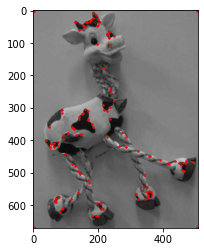

In [8]:
img1 = np.array(Image.open('img/toyHorse1.png'))
display(img1,2,0.04,6,2)
img2 = np.array(Image.open('img/toyHorse2.png'))
display(img2,2,0.04,10,2)

First of all, as you can see, there are some difference between these two images;

1 - Different dynamic ranges

2 - Different point of views

3 - Different brightness

According to these differences, we can say that corner detection by using fixed threshold is variant for point of view and affine transformation of brightness with multiplication. And also invariant for image rotation, affine transformation with addition. Because while adding same value or rotating image we are not changing any derivations. but multiplying pixels with some fixed value or changing point of view will change the derivations of the image.